# MMathCoT‑1M | Distilled
---

A clean, end‑to‑end, Colab‑friendly notebook to use the sharded MMathCot-1M image mirror on Hugging Face and perform a distillation.

## Table of Contents
---
**Part 1: (Load Images)**
1. [Install & Imports](#1-install--imports)
2. [Config & Auth](#2-config--auth)
3. [Load Dataset Metadata](#3-load-dataset-metadata)
4. [Fetch Manifest & Build Resolver](#4-fetch-manifest--build-resolver)
5. [Quick Sanity Checks](#5-quick-sanity-checks)

**Part 2: (Distill Dataset)**
1. [Explore MMathCoT-1M](#1-explore-mmathcot-1m)
2. [Filter MMathCoT-1M](#2-filter-mmathcot-1m)

## Part 1: (Load Images)
---

### 1. Install & Imports
---

In [2]:
%%capture
%pip -q install huggingface_hub datasets pandas pillow tqdm python-dotenv matplotlib

In [3]:
from pathlib import Path
from typing import Dict, Optional, List
import os, io, tarfile, json, time, random

import pandas as pd
from PIL import Image
from math import ceil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from huggingface_hub import HfApi, hf_hub_download, create_repo, list_repo_files

### 2. Config & Auth
---

In [4]:
HF_DATASET_REPO_ID = "michaelburiek/mmathcot1m-images"

BASE_DIR   = Path("./mmathcot1m_runtime").resolve()
CACHE_DIR  = BASE_DIR / "_cache"
SHARD_DIR  = BASE_DIR / "shards"
INDEX_DIR  = BASE_DIR / "_indexes"

for d in [BASE_DIR, CACHE_DIR, SHARD_DIR, INDEX_DIR]:
    d.mkdir(parents=True, exist_ok=True)

HF_TOKEN = os.environ.get("HF_TOKEN","").strip()
if not HF_TOKEN:
    print("[WARN] No HF_TOKEN in env. Proceeding anonymously; set one if your repo is private.")
api = HfApi()
try:
    who = api.whoami(token=HF_TOKEN) if HF_TOKEN else {"name": "(anon)"}
    print(f"[INFO] Authenticated as: {who.get('name')}")
except Exception as e:
    print("[WARN] whoami failed. Proceeding anonymously.", e)

[INFO] Authenticated as: michaelburiek


### 3. Load Dataset Metadata
---

In [5]:
print("[INFO] Loading MMathCoT-1M metadata...")
ds = load_dataset("URSA-MATH/MMathCoT-1M", split="train")
print(f"[INFO] Rows: {len(ds):,}")

unique_urls = sorted(set([ds[i].get("image_url","") for i in range(len(ds)) if ds[i].get("image_url","")]))
print(f"[INFO] Unique image URLs: {len(unique_urls):,}")

[INFO] Loading MMathCoT-1M metadata...
[INFO] Rows: 1,019,059
[INFO] Unique image URLs: 574,534


### 4. Fetch Manifest & Build Resolver
---

In [ ]:
print("[INFO] Downloading manifest.csv from dataset repo...")
manifest_path = hf_hub_download(
    repo_id=HF_DATASET_REPO_ID,
    filename="manifest.csv",
    repo_type="dataset",
    local_dir=str(BASE_DIR),
    token=HF_TOKEN or None
)
manifest = pd.read_csv(manifest_path)
print(f"[INFO] Loaded manifest with {len(manifest):,} rows")
if not {"image_url","rel_path"}.issubset(set(manifest.columns)):
    raise RuntimeError("manifest.csv must contain 'image_url' and 'rel_path' columns.")

print("[INFO] Listing shards/ in repo...")
files = list_repo_files(HF_DATASET_REPO_ID, repo_type="dataset", token=HF_TOKEN or None)
shard_names = sorted([f.split("shards/")[1] for f in files if f.startswith("shards/") and f.endswith(".tar")])
print(f"[INFO] Found {len(shard_names)} shard(s)")

[INFO] Downloading manifest.csv from dataset repo...


manifest.csv:   0%|          | 0.00/151M [00:00<?, ?B/s]

[INFO] Loaded manifest with 574,534 rows
[INFO] Listing shards/ in repo...
[INFO] Found 6 shard(s)


In [6]:
class ShardedImageResolver:
    def __init__(self, repo_id: str, shard_names: List[str], shard_dir: Path, index_dir: Path, token: Optional[str] = None):
        self.repo_id = repo_id
        self.shard_names = shard_names
        self.shard_dir = Path(shard_dir)
        self.index_dir = Path(index_dir)
        self.token = token
        self.url_to_shard: Dict[str, str] = {}
        self._load_global_mapping()

    def _global_map_path(self) -> Path:
        return self.index_dir / "url_to_shard.json"

    def _load_global_mapping(self):
        p = self._global_map_path()
        if p.exists():
            try:
                self.url_to_shard = json.loads(p.read_text())
            except Exception:
                self.url_to_shard = {}
        else:
            self.url_to_shard = {}

    def _save_global_mapping(self):
        self.index_dir.mkdir(parents=True, exist_ok=True)
        tmp = self._global_map_path().with_suffix(".tmp")
        tmp.write_text(json.dumps(self.url_to_shard))
        tmp.replace(self._global_map_path())

    def _shard_index_path(self, shard_name: str) -> Path:
        safe = shard_name.replace("/", "_")
        return self.index_dir / f"{safe}.members.json"

    def _ensure_shard_index(self, shard_name: str) -> set:
        idx_path = self._shard_index_path(shard_name)
        if idx_path.exists():
            try:
                return set(json.loads(idx_path.read_text()))
            except Exception:
                pass
        local_tar = hf_hub_download(
            repo_id=self.repo_id,
            filename=f"shards/{shard_name}",
            repo_type="dataset",
            local_dir=str(self.shard_dir),
            token=self.token or None
        )
        names = set()
        with tarfile.open(local_tar, "r") as tf:
            for m in tf.getmembers():
                names.add(m.name)
        idx_path.parent.mkdir(parents=True, exist_ok=True)
        idx_path.write_text(json.dumps(sorted(names)))
        return names

    def _open_from_shard(self, shard_name: str, member_name: str) -> Image.Image:
        local_tar = hf_hub_download(
            repo_id=self.repo_id,
            filename=f"shards/{shard_name}",
            repo_type="dataset",
            local_dir=str(self.shard_dir),
            token=self.token or None
        )
        with tarfile.open(local_tar, "r") as tf:
            ex = tf.extractfile(member_name)
            if ex is None:
                raise FileNotFoundError(member_name)
            data = ex.read()
        return Image.open(io.BytesIO(data)).convert("RGB")

    def get_image(self, image_url: str) -> Image.Image:
        shard = self.url_to_shard.get(image_url)
        if shard:
            return self._open_from_shard(shard, image_url)
        for shard_name in self.shard_names:
            names = self._ensure_shard_index(shard_name)
            if image_url in names:
                self.url_to_shard[image_url] = shard_name
                if len(self.url_to_shard) % 100 == 0:
                    self._save_global_mapping()
                return self._open_from_shard(shard_name, image_url)
        raise FileNotFoundError(f"{image_url} not found in shards.")

resolver = ShardedImageResolver(
    repo_id=HF_DATASET_REPO_ID,
    shard_names=shard_names,
    shard_dir=SHARD_DIR,
    index_dir=INDEX_DIR,
    token=HF_TOKEN or None
)
print("[INFO] Resolver ready.")

[INFO] Resolver ready.


In [12]:
sample_urls = random.sample(unique_urls, k=min(12, len(unique_urls)))
images = []
ok, fail = 0, 0
for u in sample_urls:
    try:
        im = resolver.get_image(u)
        images.append((u, im))
        ok += 1
    except Exception as e:
        fail += 1
        print("[MISS]", u, e)
print(f"[INFO] Samples OK: {ok}, MISS: {fail}")

shards/images-000.tar:   0%|          | 0.00/5.07G [00:00<?, ?B/s]

### 5. Quick Sanity Checks
---

In [ ]:
print("[INFO] Testing first 10 dataset rows with images...")

n_samples = 10
samples = []
ok, fail = 0, 0

for i in range(min(n_samples, len(ds))):
    row = ds[i]
    image_url = row.get("image_url", "")
    
    print(f"[{i+1}/{n_samples}] Processing row {i}...", end=" ")
    
    if not image_url:
        print("No image URL")
        fail += 1
        continue
    
    try:
        img = resolver.get_image(image_url)
        samples.append({
            "id": i,
            "instruction": row.get("instruction", ""),
            "output": row.get("output", ""),
            "image_url": image_url,
            "image": img
        })
        print(f"{img.size}")
        ok += 1
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        fail += 1

print(f"\n[INFO] Successfully loaded {ok}/{n_samples} question-image pairs")

[INFO] Testing first 10 dataset rows with images...
[1/10] Processing row 0... (473, 235)
[2/10] Processing row 1... (499, 235)
[3/10] Processing row 2... (640, 640)
[4/10] Processing row 3... (224, 146)
[5/10] Processing row 4... (700, 500)
[6/10] Processing row 5... (432, 128)
[7/10] Processing row 6... (640, 427)
[8/10] Processing row 7... (289, 299)
[9/10] Processing row 8... (2153, 1741)
[10/10] Processing row 9... (1999, 1977)

[INFO] Successfully loaded 10/10 question-image pairs



QUESTION 1 (Dataset Row 0)

QUESTION:
you are given a math problem image, please solve the problem step by step. 
Question:Based on the image, can we determine the type of triangle by knowing the lengths of its sides?
Choices:
A. Yes
B. No

IMAGE: textbook_collect_1220-100_170.png


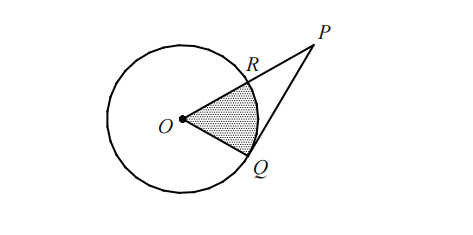


ANSWER:
Step 1: We are given a triangle and asked if we can determine its type knowing the lengths of its sides.
Step 2: The solution states that if a right triangle has a hypotenuse twice as long as the shorter leg, it's a 30-60-90 triangle.
Step 3: This implies that knowing side lengths allows triangle ty... (truncated)


QUESTION 2 (Dataset Row 1)

QUESTION:
you are given a math problem image, please solve the problem step by step. 
Question:The degree measure of a minor arc and a major arc are x and y respectively. If m \angle A B C = 70, find y.
Choices:
(A) 110
(B) 180
(C) 250
(D) 270

IMAGE: 1604.png


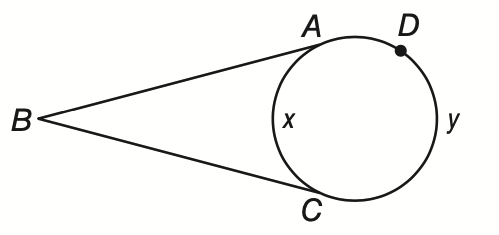


ANSWER:
Step 1: We are given that the measure of the angle ABC is 70 degrees.  This angle is formed by two tangents from point B to the circle.

Step 2: The measure of the angle formed by two tangents drawn from an external point to a circle is half the difference of the measures of the intercepted arcs. In... (truncated)


QUESTION 3 (Dataset Row 2)

QUESTION:
you are given a math problem image, please solve the problem step by step. 
Question:Determine the measurement of side x in the given geometric figure. Please round your answer to the closest hundredth. The answer options you can choose from are as follows: Cannot be computed, 4, 8.13, 12, or 5.03.

IMAGE: 0-749.png


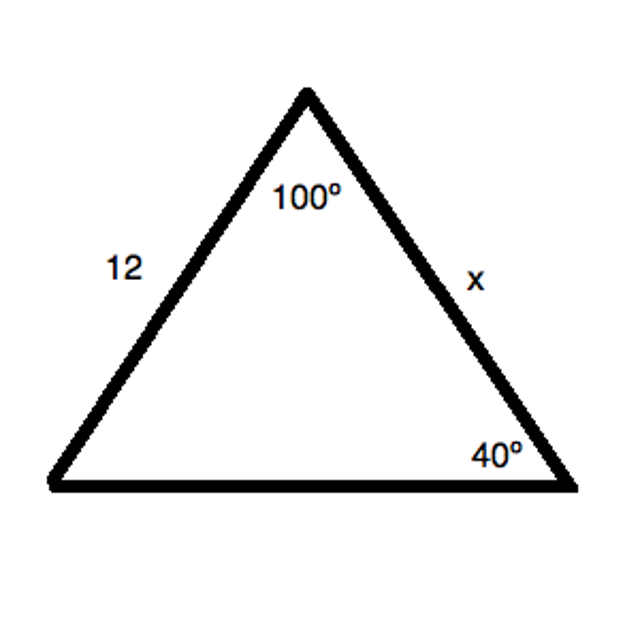


ANSWER:
Step 1: Determine the missing angle in the triangle.  A triangle's angles sum to 180°, so the missing angle is 180° - 100° - 40° = 40°.

Step 2: Identify the triangle type. Since two angles are equal (40° and 40°), the triangle is an isosceles triangle.

Step 3: Apply the property of isosceles trian... (truncated)


QUESTION 4 (Dataset Row 3)

QUESTION:
you are given a math problem image, please solve the problem step by step. 
Question:estion: Based on the image, what fraction represents the relationship between the area and base of the parallelogram?

IMAGE: shlab_collect_1226_157.png


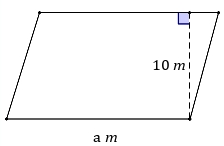


ANSWER:
Step 1: The area of a parallelogram is given by the formula: Area = base × height.
Step 2: We are given that the area is 180 m² and the height is 10 m.
Step 3: To find the base, we rearrange the formula: base = Area / height.
Step 4: Substituting the given values, we get: base = 180 m² / 10 m = 18 m... (truncated)


QUESTION 5 (Dataset Row 4)

QUESTION:
you are given a math problem image, please solve the problem step by step. 
Question:What is the value of the state with the darkest color shade?

IMAGE: map_2267.png


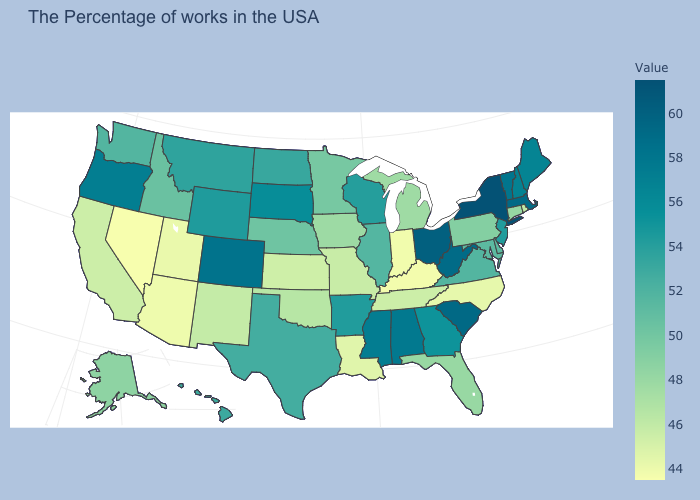


ANSWER:
Step 1: Observe the provided choropleth map of the USA.  The map shows the percentage of works in each state, represented by different shades of color.

Step 2: Identify the color scale on the right side of the map. The scale indicates that darker shades of teal correspond to higher percentages.

St... (truncated)


QUESTION 6 (Dataset Row 5)

QUESTION:
you are given a math problem image, please solve the problem step by step. 
Question:Which of the two lines has a shorter measurement? Possible Answers: Line B, They are of equal length, Line A.

IMAGE: 28-205.png


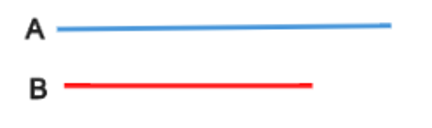


ANSWER:
Step 1: Compare the lengths of line A and line B.
Step 2: Determine which line is shorter.
Step 3: Conclude that line B is shorter than line A.
†Answer: Line B


QUESTION 7 (Dataset Row 6)

QUESTION:
you are given a math problem image, please solve the problem step by step. 
Question:Is the landscape flat?

IMAGE: 156768.jpg


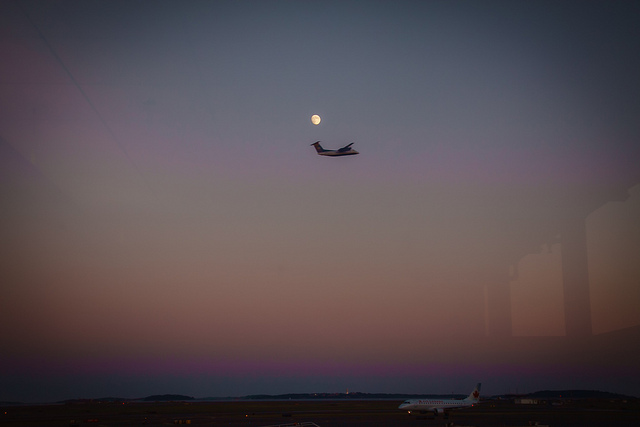


ANSWER:
Step 1: Observe the image. The image shows a landscape with a horizon line.

Step 2: Analyze the horizon line. The horizon line is not perfectly straight, indicating some undulation in the terrain.

Step 3: Consider the presence of land beyond the horizon. The land beyond the horizon appears to have... (truncated)


QUESTION 8 (Dataset Row 7)

QUESTION:
you are given a math problem image, please solve the problem step by step. 
Question:Based on the image, if the hypotenuse is 13 units long, what could be the possible lengths for the other two sides?
Choices:
A. 5 units, 12 units
B. 8 units, 15 units
C. 9 units, 12 units
D. 11 units, 12 units

IMAGE: shlab_collect_0104_76.png


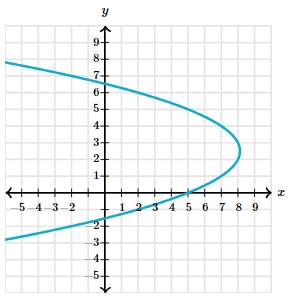


ANSWER:
Step 1: The Pythagorean theorem states that in a right-angled triangle, the square of the hypotenuse is equal to the sum of the squares of the other two sides.  The hypotenuse is given as 13 units.

Step 2: We test option A: 5² + 12² = 25 + 144 = 169 = 13². This satisfies the Pythagorean theorem.

S... (truncated)


QUESTION 9 (Dataset Row 8)

QUESTION:
you are given a math problem image, please solve the problem step by step. 
Question:AB totals 10.0, Angle C measures 33. What is the side length FE in the shape DBEF?
Choices:
A: 7.5
B: 15.0
C: 11.0
D: 14.0

IMAGE: 34370_vision_dom.jpg


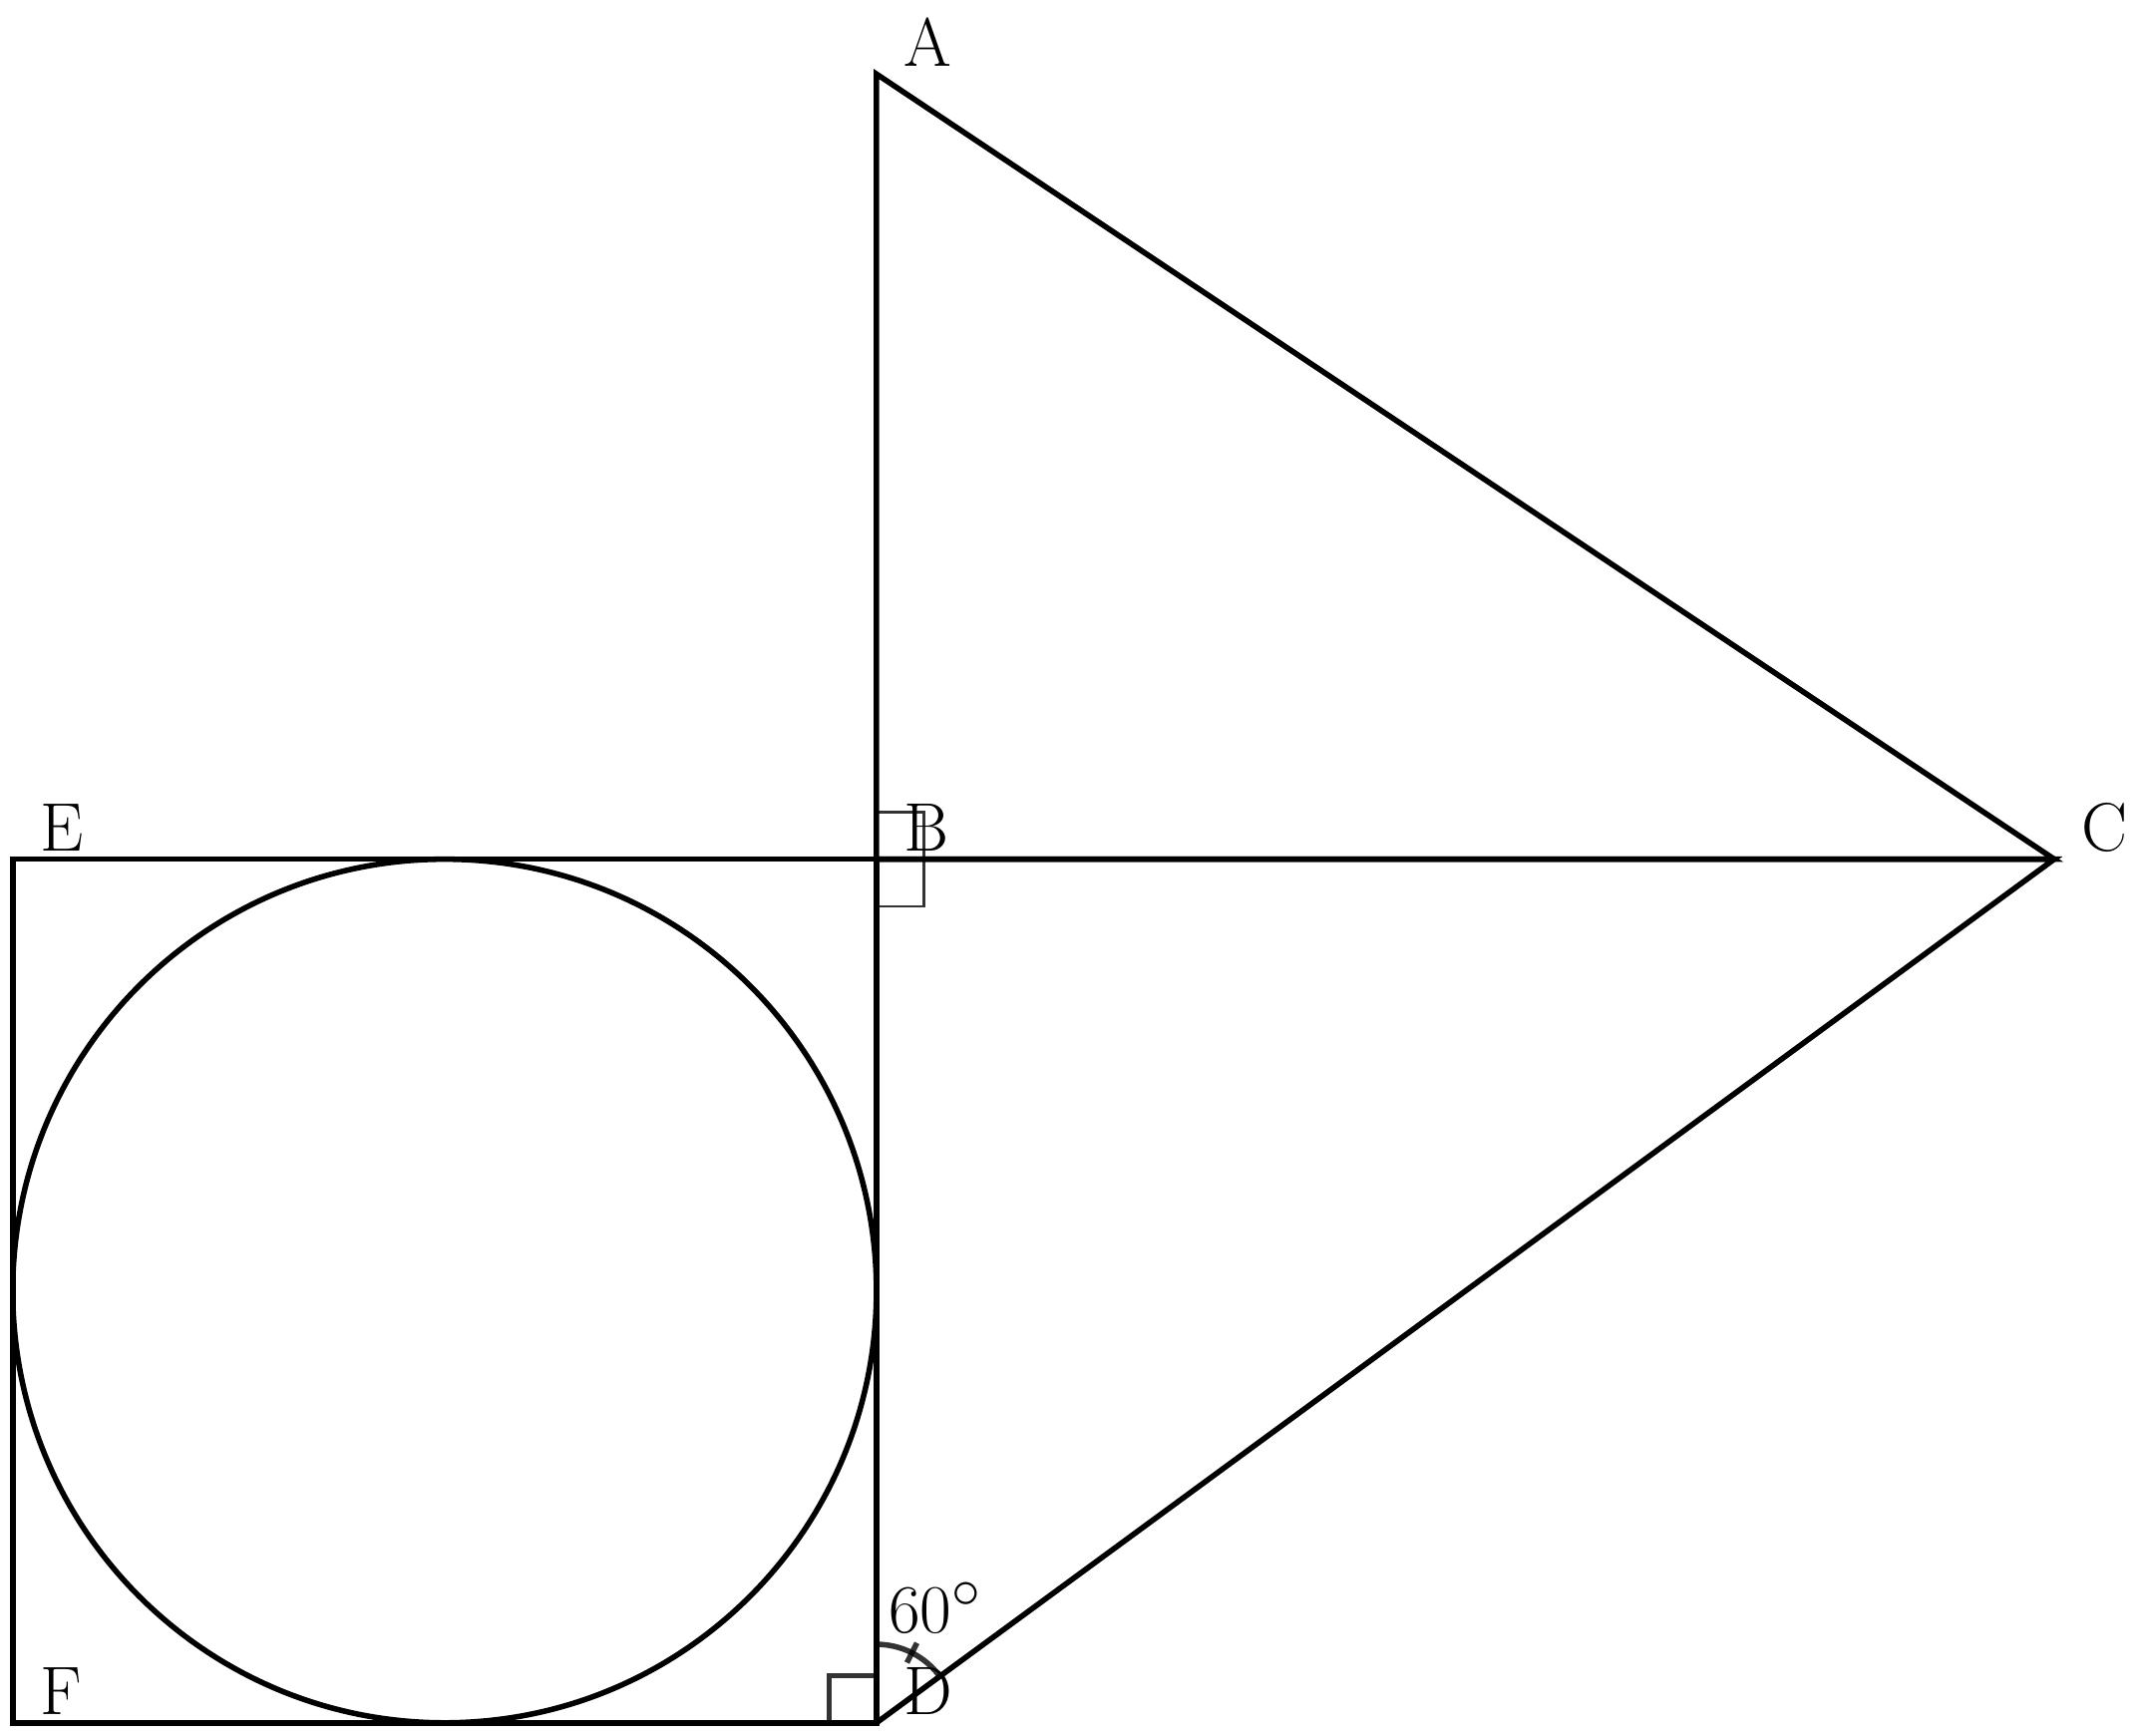


ANSWER:
Step 1: We are given AB = 10.0 and angle C = 33°.  We can use the tangent function to find BC: BC = AB / tan(33°) = 10.0 / 0.67 = 15.0.

Step 2: We are given that angle D = 53° and CB = 15.0. We can use the tangent function again to find BD: BD = CB / tan(53°) = 15.0 / 1.36 = 11.0.

Step 3: Since DB... (truncated)


QUESTION 10 (Dataset Row 9)

QUESTION:
you are given a math problem image, please solve the problem step by step. 
Question:AB is equal to 12.0. In shape EBGH, how long is GB?
Choices:
A: 12.0
B: 16.5
C: 15.5
D: 9.5

IMAGE: 34341_vision_dom.jpg


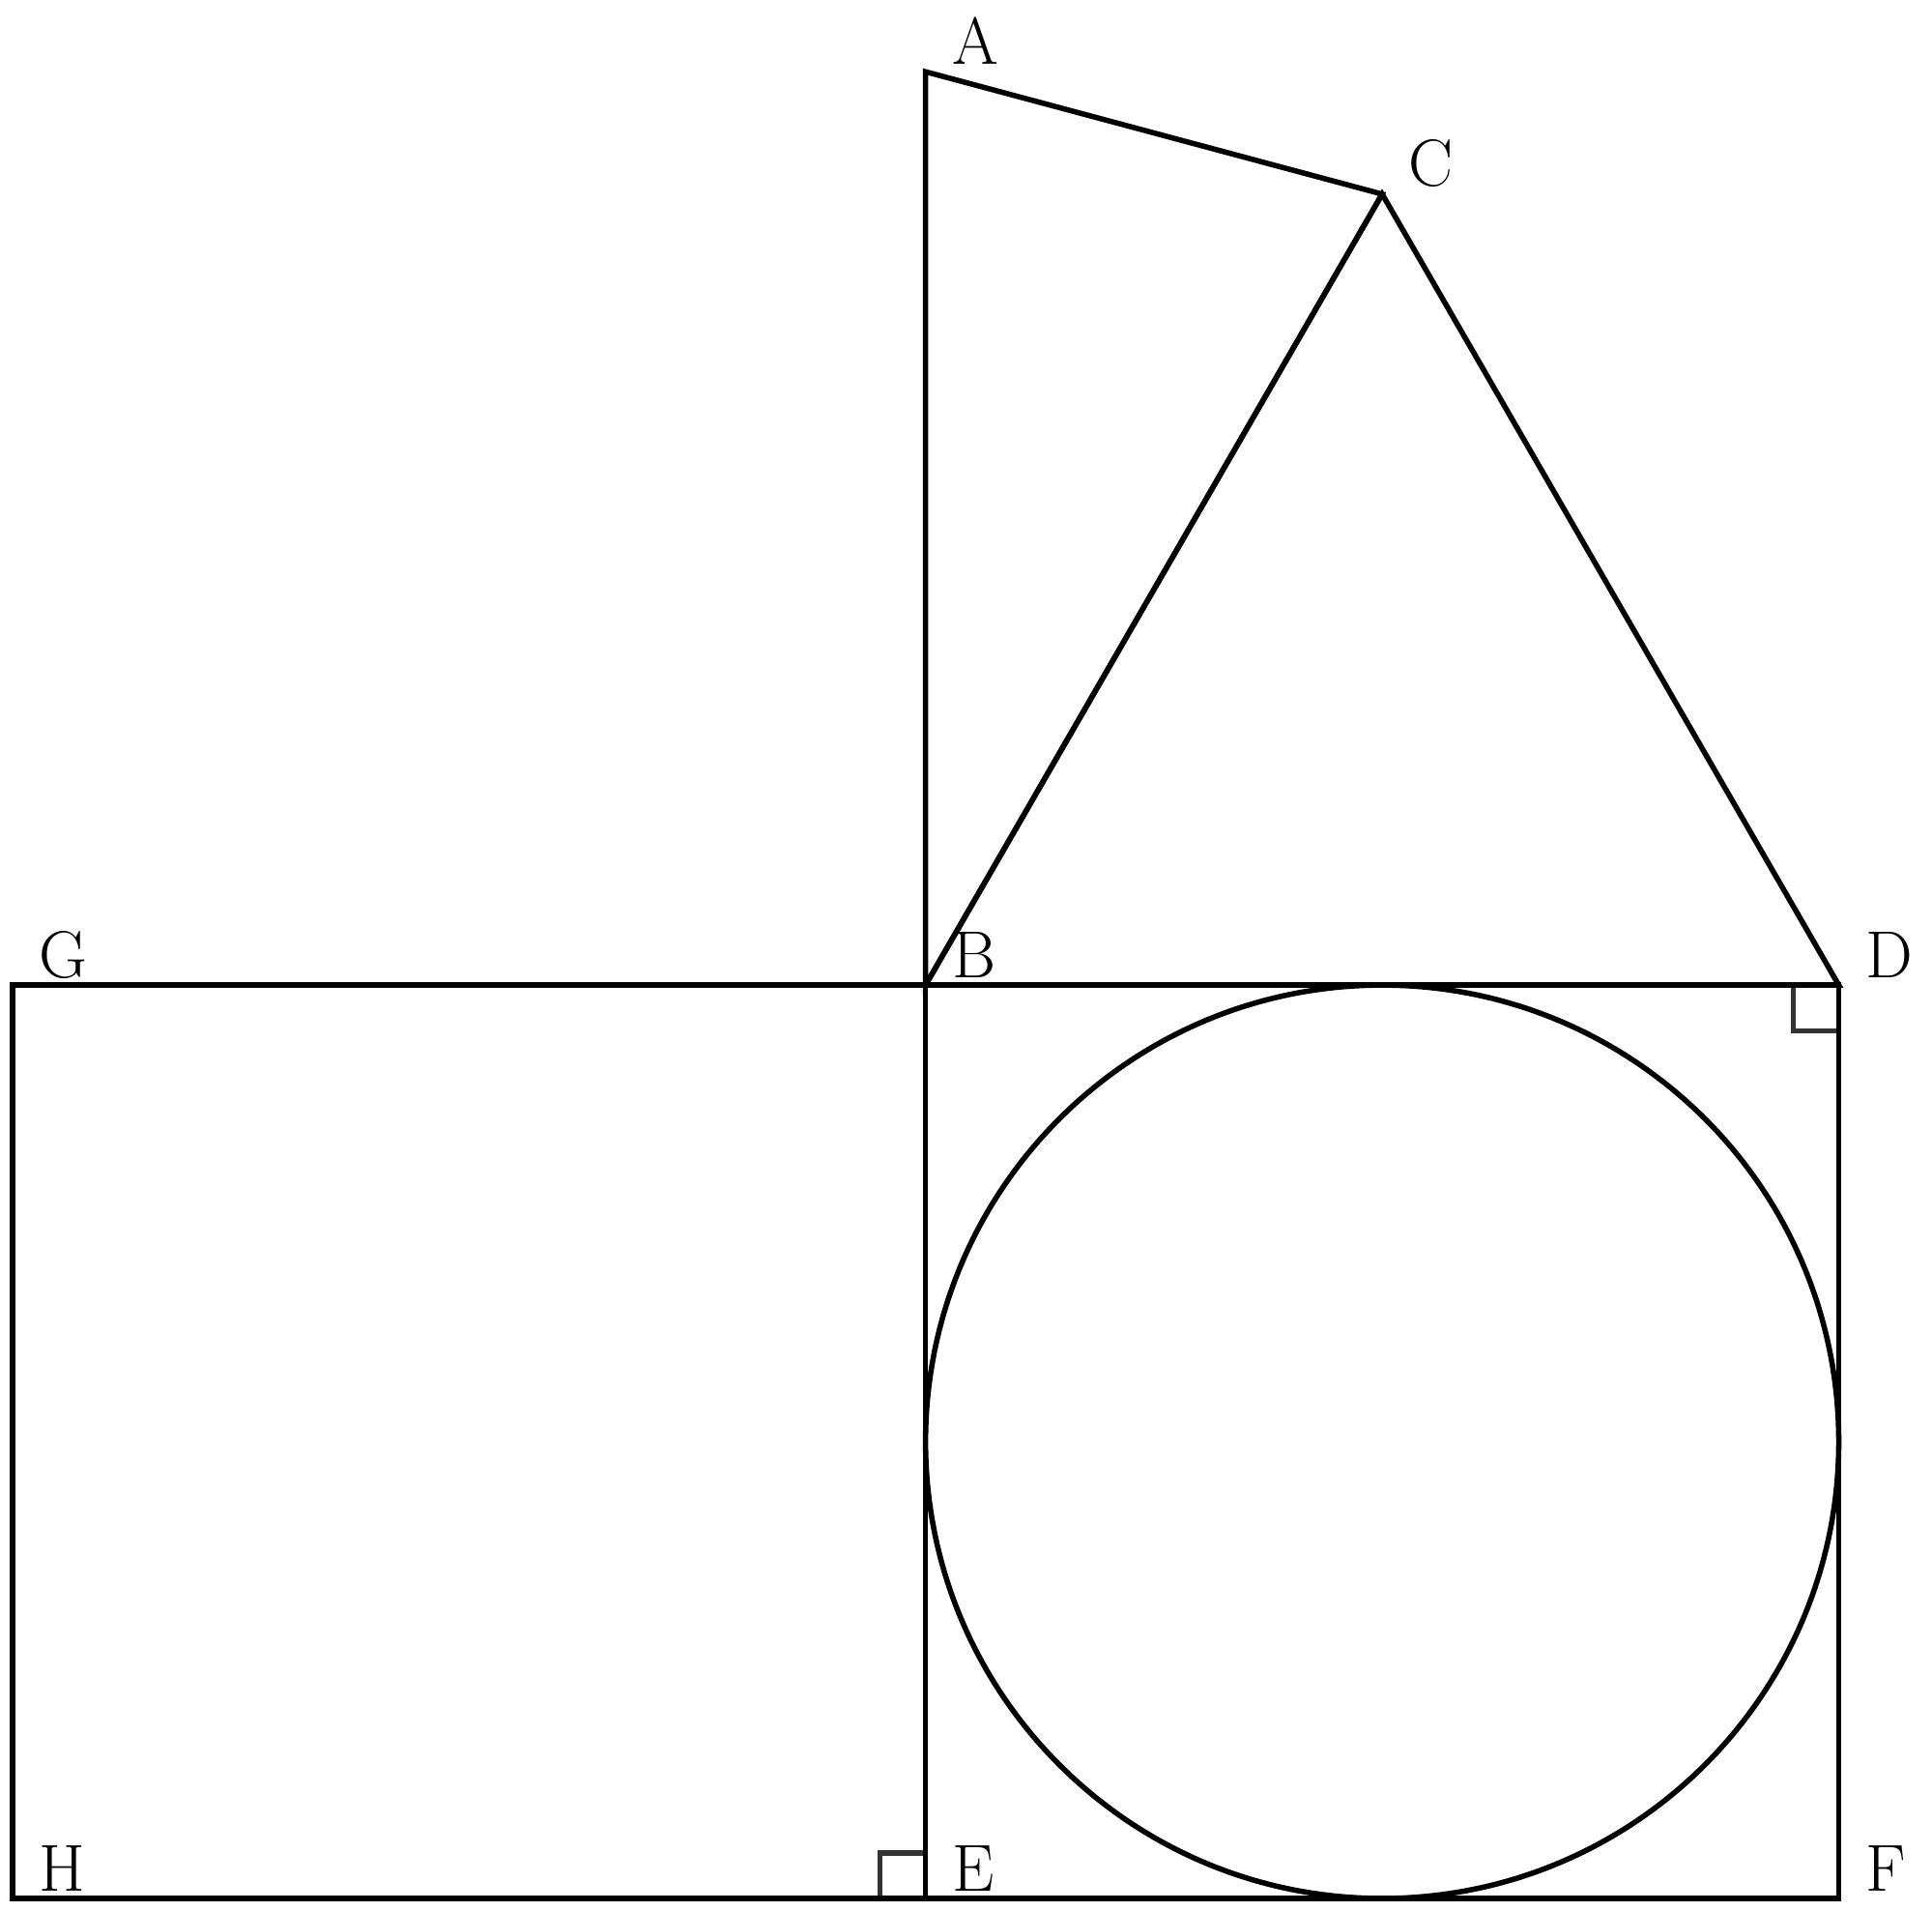


ANSWER:
Step 1: AB measures 12.0, and since triangle ABC is isosceles, BC is also 12.0.
Step 2: CB is 12.0, and triangle CBD is isosceles, so BD is also 12.0.
Step 3: DB measures 12.0, and since DBEF is a square, all sides are identical. Therefore, EB = DB = 12.0.
Step 4: EB is equal to 12.0, and since EBGH... (truncated)



In [15]:
if not samples:
    print("[ERROR] No samples loaded. Check the errors above.")
else:
    for i, sample in enumerate(samples, 1):
        print(f"\n{'='*100}")
        print(f"QUESTION {i} (Dataset Row {sample['id']})")
        print(f"{'='*100}")
        
        # Show question
        print(f"\nQUESTION:")
        print(sample['instruction'])
        
        # Show image
        print(f"\nIMAGE: {sample['image_url'].split('/')[-1]}")
        display(sample['image'])
        
        # Show answer (truncated)
        answer_preview = sample['output'][:300]
        if len(sample['output']) > 300:
            answer_preview += "... (truncated)"
        print(f"\nANSWER:")
        print(answer_preview)
        print()

## Part 2: (Distill Dataset)
---

**Methodology:**

**[STEP 1]:** Filter out math problems that can be solved without images. (LLM | Qwen2.5-Math-7B-Instruct)
- Sometimes the LLM can be too clever:
    ```text
    Question: Based on the image, can we determine the type of triangle by knowing the lengths of its sides?
    Choices: A. Yes B. No
    Ground Truth: A

    → Has visual reference in question: True
    → LLM can solve without image: True
    → LLM Answer: A
    → Ground Truth: A
    → Match: True
    ```
- If a question has strong visual dependency phrases, automatically KEEP it without testing.

**[STEP 2]:** Classify questions on their difficulty. (VLM | Qwen2.5-VL-7B-Instruct)
- Using Qwen2.5-Math-7B for difficulty assessment b/c:
    - Relative ranking is what matters - attempting to find the hardest problems in current dataset.
    - Self-consistency measures variance, not absolute accuracy
    - Cost/speed matter when evaluating thousands of examples
    - Math-specialized model is ideal for this domain
- Leveraging the following strategies to assign a difficulty score:
    - [Self-Consistency](https://arxiv.org/abs/2203.11171)
    - [MATH Dataset](https://arxiv.org/abs/2103.03874)
    - [Pass@k Metrics](https://arxiv.org/abs/2107.03374)
    - [Let's Verify Step by Step](https://arxiv.org/abs/2305.20050)

**Resources:**
- [MMathCoT-1M](https://huggingface.co/datasets/URSA-MATH/MMathCoT-1M)
- [Data-Preproc](https://github.com/penfever/data-preproc/tree/main)
- [Qwen2.5-Math-7B-Instruct](https://huggingface.co/unsloth/Qwen2.5-Math-7B-Instruct)
- [Qwen2.5-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2.5-VL-7B-Instruct)

### 1. Explore MMathCoT-1M
---

In [6]:
df = ds.to_pandas()
print(f"[INFO] Rows: {len(ds):,}")
print(f"[INFO] Columns: {df.columns.tolist()}")
print(df.head(1).T)

[INFO] Rows: 1,019,059
[INFO] Columns: ['image_url', 'instruction', 'output']
                                                             0
image_url    Mavis_Extra/meta_gen/textbook_collect_1220-100...
instruction  you are given a math problem image, please sol...
output       Step 1: We are given a triangle and asked if w...


In [7]:
import re
from collections import Counter

def extract_source(url):
    if pd.isna(url):
        return "Unknown"

    url_lower = url.lower()

    if 'mathv-360k' in url_lower or 'mathv_360k' in url_lower:
        return 'MathV-360k'
    elif 'multimath' in url_lower:
        return 'Multimath-EN'
    elif 'mavis' in url_lower:
        if 'meta_gen' in url_lower or 'metagen' in url_lower:
            return 'MAVIS MetaGen'
        elif 'caption' in url_lower:
            return 'MAVIS Caption'
        else:
            return 'MAVIS'
    elif 'varsity' in url_lower:
        return 'VarsityTutors'
    elif 'geo170k' in url_lower:
        if 'qa' in url_lower:
            return 'Geo170k-QA'
        elif 'alignment' in url_lower:
            return 'Geo170k-Alignment'
        else:
            return 'Geo170k'
    else:
        parts = url.split('/')
        if len(parts) > 0:
            return parts[0]
        return "Unknown"

# Extract sources
print("Extracting data sources from image_url...")
df['source'] = df['image_url'].apply(extract_source)

# Count distribution
source_counts = df['source'].value_counts()
print("\nData Source Distribution:")
print(source_counts)
print(f"\nTotal: {source_counts.sum():,}")

# Calculate percentages
source_pct = (source_counts / source_counts.sum() * 100).round(1)
print("\nPercentages:")
for source, pct in source_pct.items():
    print(f"{source}: {pct}%")

Extracting data sources from image_url...

Data Source Distribution:
source
MathV-360k             319619
Multimath-EN           264205
DataEngine_Geometry    186471
MAVIS MetaGen           83023
MAVIS                   58383
VarsityTutors           55162
Geo170k-QA              52196
Name: count, dtype: int64

Total: 1,019,059

Percentages:
MathV-360k: 31.4%
Multimath-EN: 25.9%
DataEngine_Geometry: 18.3%
MAVIS MetaGen: 8.1%
MAVIS: 5.7%
VarsityTutors: 5.4%
Geo170k-QA: 5.1%


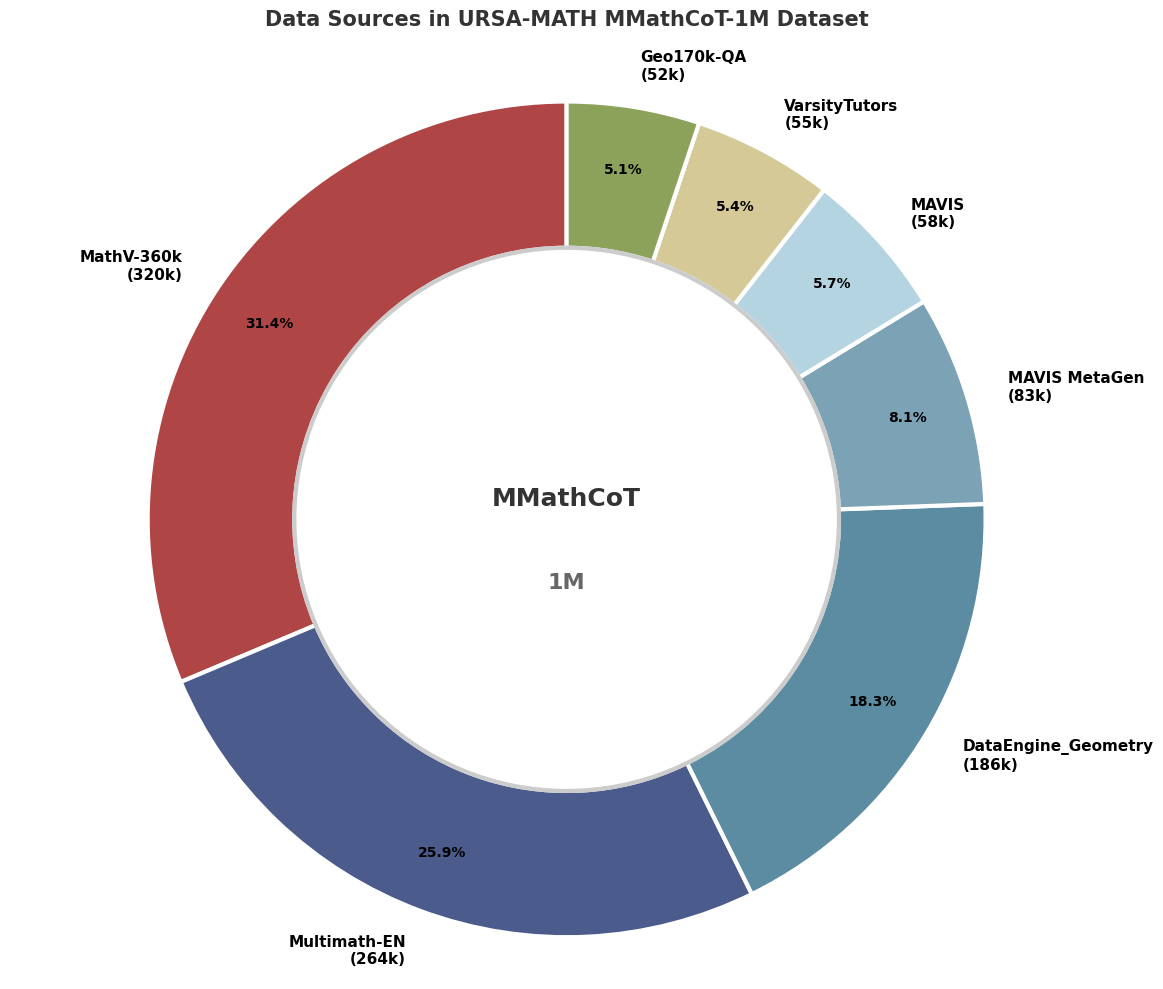

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

source_counts = df['source'].value_counts()

fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')

colors = [
    '#B04545',  # Red
    '#4A5B8C',  # Navy
    '#5B8CA2',  # Steel blue
    '#7BA2B5',  # Light blue
    '#B5D4E1',  # Very light blue
    '#D4C997',  # Tan
    '#8CA25B',  # Olive
]

labels = []
for source, count in source_counts.items():
    count_k = count / 1000
    labels.append(f'{source}\n({count_k:.0f}k)')

sizes = source_counts.values
percentages = (sizes / sizes.sum() * 100)

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(sizes)],
    wedgeprops={'width': 0.35, 'edgecolor': 'white', 'linewidth': 3},
    textprops={'fontsize': 11, 'weight': 'bold'},
    pctdistance=0.85
)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

centre_circle = Circle((0, 0), 0.65, fc='white', linewidth=3, edgecolor='#CCCCCC')
ax.add_artist(centre_circle)

ax.text(0, 0.05, 'MMathCoT',
        ha='center', va='center',
        fontsize=18, weight='bold', color='#333333')
ax.text(0, -0.15, '1M',
        ha='center', va='center',
        fontsize=16, weight='bold', color='#666666')

plt.title('Data Sources in URSA-MATH MMathCoT-1M Dataset',
          fontsize=15, weight='bold', pad=25, color='#333333')

ax.axis('equal')
plt.tight_layout()
plt.show()

### 2. Filter MMathCoT-1M
---

In [ ]:
#@title 1.1 | Login to Hugging Face
from huggingface_hub import login
from google.colab import userdata

hf_token = userdata.get("HF_TOKEN")
if hf_token is None:
    raise ValueError("No HF_TOKEN found. Add it in Colab Secrets.")

login(token=hf_token)
print("Logged in to Hugging Face")

In [ ]:
#@title Helper Functions for MMathCoT Dataset Processing

import re

print("="*100)
print("LOADING HELPER FUNCTIONS")
print("="*100)

# ============================================================================
# PARSING FUNCTIONS
# ============================================================================

def parse_mmathcot_example(instruction, output):
    """
    Parse MMathCoT structure to extract question, choices, and answer
    
    Args:
        instruction: The question/instruction text from dataset
        output: The solution/output text from dataset
        
    Returns:
        tuple: (question, choices, ground_truth)
    """
    # Remove standard prefix
    question = re.sub(
        r'^you are given a math problem image,?\s*please solve the problem step by step\.?\s*',
        '',
        instruction,
        flags=re.IGNORECASE
    ).strip()

    # Remove "Question:" prefix
    question = re.sub(r'^Question:\s*', '', question, flags=re.IGNORECASE).strip()

    # Extract choices if present
    choices_match = re.search(r'Choices?:\s*(.+)$', question, re.IGNORECASE | re.DOTALL)
    choices = None
    if choices_match:
        choices = choices_match.group(1).strip()
        question = question[:choices_match.start()].strip()

    # Extract ground truth answer
    answer_match = re.search(r'[†‡]?\s*Answer:\s*([^\n]+)', output, re.IGNORECASE)
    if answer_match:
        ground_truth = answer_match.group(1).strip()
    else:
        # Fallback: last line
        lines = output.strip().split('\n')
        ground_truth = lines[-1].strip() if lines else None

    return question, choices, ground_truth


def extract_ground_truth(output_text):
    """
    Extract ground truth answer from output text
    
    Args:
        output_text: Solution/output text
        
    Returns:
        str: Ground truth answer or None
    """
    # Look for answer marker
    if "####" in output_text:
        return output_text.split("####")[-1].strip()
    
    # Try common patterns
    patterns = [
        r'[†‡]?\s*Answer:\s*([^\n]+)',
        r'(?:answer|solution):\s*([^\n]+)',
        r'\\boxed\{([^\}]+)\}',
    ]
    
    for pattern in patterns:
        match = re.search(pattern, output_text, re.IGNORECASE)
        if match:
            return match.group(1).strip()
    
    return None


# ============================================================================
# VISUAL DEPENDENCY FUNCTIONS
# ============================================================================

def has_strong_visual_dependency(question):
    """
    Check if question explicitly requires image/visual input
    
    Args:
        question: Question text
        
    Returns:
        bool: True if question has explicit visual references
    """
    strong_visual_phrases = [
        r'based on the (image|figure|diagram|graph|picture|illustration)',
        r'according to the (image|figure|diagram|graph|picture|illustration)',
        r'in the (image|figure|diagram|graph|picture|illustration)',
        r'from the (image|figure|diagram|graph|picture|illustration)',
        r'as shown in( the)?',
        r'refer to the (image|figure|diagram|graph)',
        r'shown (in|below|above)',
        r'see (the )?(image|figure|diagram|graph)',
        r'observe (the )?(image|figure|diagram|graph)',
    ]

    question_lower = question.lower()
    for pattern in strong_visual_phrases:
        if re.search(pattern, question_lower):
            return True
    return False


def remove_image_references(question):
    """
    Remove image/visual references from question text
    
    Args:
        question: Question text with possible image references
        
    Returns:
        str: Cleaned question text
    """
    patterns = [
        r'based on the (image|figure|diagram|graph|picture|illustration),?\s*',
        r'according to the (image|figure|diagram|graph|picture|illustration),?\s*',
        r'in the (image|figure|diagram|graph|picture|illustration)( shown| above| below)?,?\s*',
        r'from the (image|figure|diagram|graph|picture|illustration),?\s*',
        r'as shown( in the (image|figure|diagram|graph|picture|illustration))?,?\s*',
        r'refer to the (image|figure|diagram|graph|picture|illustration),?\s*',
        r'see the (image|figure|diagram|graph|picture|illustration),?\s*',
        r'\[IMAGE\]',
        r'<image>',
    ]

    cleaned = question
    for pattern in patterns:
        cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)

    return cleaned.strip()


# ============================================================================
# ANSWER EXTRACTION & NORMALIZATION
# ============================================================================

def extract_final_answer(text, choices=None):
    """
    Extract final answer from LLM/VLM output text
    
    Args:
        text: Generated response text
        choices: Multiple choice options if applicable
        
    Returns:
        str: Extracted answer or None
    """
    # Look for answer patterns
    answer_patterns = [
        r'[†‡]?\s*(?:final\s+)?answer:\s*([^\n]+)',
        r'\\boxed\{([^\}]+)\}',
        r'(?:therefore|thus|hence),?\s*(?:the\s+)?answer\s+is\s+([^\n\.]+)',
        r'(?:the\s+)?(?:correct\s+)?(?:answer|choice)\s+is\s+([^\n\.]+)',
    ]

    text_lower = text.lower()
    for pattern in answer_patterns:
        match = re.search(pattern, text_lower)
        if match:
            answer = match.group(1).strip()
            # Extract letter if multiple choice
            letter_match = re.match(r'^([A-E])', answer, re.IGNORECASE)
            if letter_match:
                return letter_match.group(1).upper()
            return answer

    # For multiple choice, look for letter at end
    if choices:
        letter_match = re.search(r'\b([A-E])\b', text[-100:], re.IGNORECASE)
        if letter_match:
            return letter_match.group(1).upper()

    # Extract last number as fallback
    numbers = re.findall(r'-?\d+\.?\d*', text)
    if numbers:
        return numbers[-1]

    return None


def normalize_answer(answer):
    """
    Normalize answer for comparison
    
    Args:
        answer: Raw answer string
        
    Returns:
        str: Normalized answer or None
    """
    if answer is None:
        return None

    answer = str(answer).strip()

    # Multiple choice: extract letter
    letter_match = re.match(r'^([A-E])', answer, re.IGNORECASE)
    if letter_match:
        return letter_match.group(1).upper()

    # Numeric: extract number
    numeric_match = re.search(r'-?\d+\.?\d*', answer)
    if numeric_match:
        return numeric_match.group(0)

    # Text: clean and lowercase
    return re.sub(r'[^\w\s]', '', answer.lower()).strip()


def compare_answers(answer1, answer2, tolerance=0.01):
    """
    Compare two answers with appropriate logic for different types
    
    Args:
        answer1: First answer
        answer2: Second answer
        tolerance: Numeric tolerance for floating point comparison
        
    Returns:
        bool: True if answers match
    """
    norm1 = normalize_answer(answer1)
    norm2 = normalize_answer(answer2)

    if not norm1 or not norm2:
        return False

    # Multiple choice: exact match
    if re.match(r'^[A-E]$', norm1) and re.match(r'^[A-E]$', norm2):
        return norm1 == norm2

    # Numeric: tolerance-based comparison
    try:
        val1 = float(norm1)
        val2 = float(norm2)
        return abs(val1 - val2) < tolerance
    except (ValueError, TypeError):
        # String match
        return norm1 == norm2


# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def get_source_from_url(image_url):
    """
    Extract source name from image URL
    
    Args:
        image_url: Full image URL from dataset
        
    Returns:
        str: Source name (e.g., 'geoqa_plus', 'mathvista')
    """
    if not image_url:
        return 'unknown'
    
    # Extract first path component
    if '/' in image_url:
        return image_url.split('/')[0]
    
    return 'unknown'


def truncate_text(text, max_length=300, suffix="..."):
    """
    Truncate text to maximum length
    
    Args:
        text: Text to truncate
        max_length: Maximum length
        suffix: Suffix to add when truncated
        
    Returns:
        str: Truncated text
    """
    if not text:
        return ""
    
    text = str(text)
    if len(text) <= max_length:
        return text
    
    return text[:max_length] + suffix


# ============================================================================
# SUMMARY
# ============================================================================

print("[INFO] Loaded 11 helper functions:")
print("  Parsing:")
print("    - parse_mmathcot_example()")
print("    - extract_ground_truth()")
print("  Visual Dependency:")
print("    - has_strong_visual_dependency()")
print("    - remove_image_references()")
print("  Answer Processing:")
print("    - extract_final_answer()")
print("    - normalize_answer()")
print("    - compare_answers()")
print("  Utilities:")
print("    - get_source_from_url()")
print("    - truncate_text()")
print("\n" + "="*100)
print("HELPER FUNCTIONS READY")
print("="*100)

#### [STEP 1]: Filter out math problems that can be solved without images. (LLM | Qwen2.5-Math-7B-Instruct)
---

In [ ]:
#@title Load LLM: `Qwen2.5-Math-7B-Instruct`
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

print("="*100)
print("Loading Qwen2.5-Math-7B-Instruct LLM")
print("="*100)

llm_model_name = "Qwen/Qwen2.5-Math-7B-Instruct"
print(f"LLM Model: {llm_model_name}")

print("Loading Auto Tokenizer...")
auto_tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
print("Auto Tokenizer loaded")

print("Loading llm model...")
llm_model = AutoModelForCausalLM.from_pretrained(
    llm_model_name,
    dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
print("LLM Model loaded")

print(f"LLM Model device: {llm_model.device}")
print(f"LLMModel dtype: {llm_model.dtype}")

In [ ]:
#@title Test LLM on First MMathCoT Question (Text-Only)
print("="*100)
print("TESTING LLM ON FIRST QUESTION (WITHOUT IMAGE)")
print("="*100)

# Get first question with an image
test_row = None
test_idx = None

for i in range(min(100, len(ds))):
    if ds[i].get('image_url'):
        test_row = ds[i]
        test_idx = i
        break

if test_row is None:
    print("ERROR: No questions with images found in first 100 rows")
else:
    print(f"\nTest Question (Row {test_idx}):")
    print(f"Original Instruction: {test_row['instruction'][:200]}...")
    
    # Parse it
    question, choices, ground_truth = parse_mmathcot_example(
        test_row['instruction'], 
        test_row['output']
    )
    
    print(f"\nParsed Question: {question[:200]}...")
    if choices:
        print(f"Choices: {choices[:100]}...")
    print(f"Ground Truth: {ground_truth}")
    
    # Check visual dependency
    has_visual = has_strong_visual_dependency(question)
    print(f"\nHas Strong Visual Dependency: {has_visual}")
    
    if not has_visual:
        # Clean and test LLM
        question_cleaned = remove_image_references(question)
        print(f"\nCleaned Question: {question_cleaned[:200]}...")
        
        # Build prompt
        if choices:
            prompt = f"""Solve this math problem step by step and select the correct answer.
Question: {question_cleaned}
Choices: {choices}
Provide your reasoning and final answer in the format: Answer: [Letter]
Solution:"""
        else:
            prompt = f"""Solve this math problem step by step.
Question: {question_cleaned}
Provide your reasoning and final answer.
Solution:"""
        
        print("\nTesting LLM inference...")
        inputs = auto_tokenizer(prompt, return_tensors="pt").to(llm_model.device)
        
        with torch.no_grad():
            outputs = llm_model.generate(
                **inputs,
                max_new_tokens=512,
                do_sample=False,
                pad_token_id=auto_tokenizer.eos_token_id
            )
        
        response = auto_tokenizer.decode(
            outputs[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )
        
        print("\nLLM Response:")
        print("-"*80)
        print(response[:500] + "..." if len(response) > 500 else response)
        print("-"*80)
        
        # Extract answer
        llm_answer = extract_final_answer(response, choices)
        print(f"\nExtracted Answer: {llm_answer}")
        print(f"Ground Truth: {ground_truth}")
        
        # Compare
        llm_norm = normalize_answer(llm_answer)
        gt_norm = normalize_answer(ground_truth)
        match = (llm_norm == gt_norm)
        
        print(f"\nNormalized LLM: {llm_norm}")
        print(f"Normalized GT: {gt_norm}")
        print(f"Match: {match}")
        
        if match:
            print("\n[RESULT] LLM can solve without image - FILTER OUT")
        else:
            print("\n[RESULT] LLM cannot solve without image - KEEP")
    else:
        print("\n[RESULT] Has explicit visual reference - AUTO KEEP")
    
    print("\n[SUCCESS] LLM is working correctly!")

In [ ]:
#@title LLM-Based Image Dependency Evaluator

import torch
import re

class LLMImageDependencyEvaluator:
    """
    Evaluate whether a math problem requires an image to solve.
    Uses text-only LLM to attempt solving without the image.
    Problems that can be solved without images are filtered out.
    """

    def __init__(self, llm_model, llm_tokenizer):
        self.model = llm_model
        self.tokenizer = llm_tokenizer
        print("[INFO] LLM ImageDependencyEvaluator initialized")

    def has_strong_visual_dependency(self, question):
        """Check if question explicitly requires image"""
        strong_visual_phrases = [
            r'based on the (image|figure|diagram|graph)',
            r'according to the (image|figure|diagram|graph)',
            r'in the (image|figure|diagram|graph)',
            r'from the (image|figure|diagram|graph)',
            r'as shown in',
            r'refer to the',
            r'shown (in|below|above)',
        ]

        question_lower = question.lower()
        for pattern in strong_visual_phrases:
            if re.search(pattern, question_lower):
                return True
        return False

    def remove_image_references(self, question):
        """Remove image references from question"""
        patterns = [
            r'based on the (image|figure|diagram|graph),?\s*',
            r'according to the (image|figure|diagram|graph),?\s*',
            r'in the (image|figure|diagram|graph)( shown| above| below)?,?\s*',
            r'from the (image|figure|diagram|graph),?\s*',
            r'as shown( in the (image|figure|diagram|graph))?,?\s*',
            r'\[IMAGE\]',
            r'<image>',
        ]

        cleaned = question
        for pattern in patterns:
            cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)

        return cleaned.strip()

    def generate_answer(self, question, choices=None, max_new_tokens=512):
        """Generate answer using text-only LLM"""
        
        # Build prompt
        if choices:
            prompt = f"""Solve this math problem step by step and select the correct answer.
Question: {question}
Choices: {choices}
Provide your reasoning and final answer in the format: Answer: [Letter]
Solution:"""
        else:
            prompt = f"""Solve this math problem step by step.
Question: {question}
Provide your reasoning and final answer.
Solution:"""

        # Generate
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=self.tokenizer.eos_token_id
            )

        response = self.tokenizer.decode(
            outputs[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )

        return response

    def extract_answer(self, text, choices=None):
        """Extract final answer from LLM output"""
        
        # Look for answer patterns
        answer_patterns = [
            r'[†‡]?\s*(?:final\s+)?answer:\s*([^\n]+)',
            r'(?:therefore|thus|hence),?\s*(?:the\s+)?answer\s+is\s+([^\n\.]+)',
            r'(?:the\s+)?(?:correct\s+)?(?:answer|choice)\s+is\s+([^\n\.]+)',
        ]

        text_lower = text.lower()
        for pattern in answer_patterns:
            match = re.search(pattern, text_lower)
            if match:
                answer = match.group(1).strip()
                # Extract letter if multiple choice
                letter_match = re.match(r'^([A-E])', answer, re.IGNORECASE)
                if letter_match:
                    return letter_match.group(1).upper()
                return answer

        # For multiple choice, look for letter at end
        if choices:
            letter_match = re.search(r'\b([A-E])\b', text[-100:], re.IGNORECASE)
            if letter_match:
                return letter_match.group(1).upper()

        # Extract last number
        numbers = re.findall(r'-?\d+\.?\d*', text)
        if numbers:
            return numbers[-1]

        return None

    def normalize_answer(self, answer):
        """Normalize answer for comparison"""
        if answer is None:
            return None

        answer = str(answer).strip()

        # Extract letter for multiple choice
        letter_match = re.match(r'^([A-E])', answer, re.IGNORECASE)
        if letter_match:
            return letter_match.group(1).upper()

        # Extract number
        numeric_match = re.search(r'-?\d+\.?\d*', answer)
        if numeric_match:
            return numeric_match.group(0)

        # Clean text
        return re.sub(r'[^\w\s]', '', answer.lower()).strip()

    def compare_answers(self, llm_answer, ground_truth):
        """Compare LLM answer with ground truth"""
        llm_norm = self.normalize_answer(llm_answer)
        gt_norm = self.normalize_answer(ground_truth)

        if not llm_norm or not gt_norm:
            return False

        # Multiple choice - exact match
        if re.match(r'^[A-E]$', gt_norm):
            return llm_norm == gt_norm

        # Numeric - allow small tolerance
        try:
            llm_val = float(llm_norm)
            gt_val = float(gt_norm)
            return abs(llm_val - gt_val) < 0.01
        except:
            # String match
            return llm_norm == gt_norm

    def evaluate(self, question, choices, ground_truth):
        """
        Evaluate if problem can be solved without image

        Args:
            question: Math problem text
            choices: Multiple choice options (or None)
            ground_truth: Expected answer

        Returns:
            Dictionary with evaluation results
        """
        
        # Check for strong visual dependency first
        has_visual_ref = self.has_strong_visual_dependency(question)
        
        if has_visual_ref:
            return {
                'requires_image': True,
                'reason': 'explicit_visual_reference',
                'has_visual_reference': True,
                'can_solve_without_image': False,
                'llm_response': None,
                'llm_answer': None,
                'ground_truth': ground_truth,
                'answers_match': False
            }

        # Remove image references
        question_cleaned = self.remove_image_references(question)

        # If question becomes too short, it needs the image
        if len(question_cleaned) < 20:
            return {
                'requires_image': True,
                'reason': 'question_too_short_after_cleaning',
                'has_visual_reference': False,
                'can_solve_without_image': False,
                'llm_response': None,
                'llm_answer': None,
                'ground_truth': ground_truth,
                'answers_match': False
            }

        # Try to solve with LLM
        llm_response = self.generate_answer(question_cleaned, choices)
        llm_answer = self.extract_answer(llm_response, choices)
        answers_match = self.compare_answers(llm_answer, ground_truth)

        # Determine if image is required
        requires_image = not answers_match

        return {
            'requires_image': requires_image,
            'reason': 'llm_failed' if requires_image else 'llm_succeeded',
            'has_visual_reference': False,
            'can_solve_without_image': answers_match,
            'llm_response': llm_response[:500],  # Truncate for storage
            'llm_answer': llm_answer,
            'ground_truth': ground_truth,
            'answers_match': answers_match,
            'llm_answer_normalized': self.normalize_answer(llm_answer),
            'ground_truth_normalized': self.normalize_answer(ground_truth)
        }

print("[INFO] LLM ImageDependencyEvaluator class loaded")

In [ ]:
#@title Run LLM Image Dependency Evaluation on Subset

# ============ CONFIGURATION ============
SUBSET_SIZE = 100  # Change this: 10, 100, 1000, 10000, etc.
RANDOM_SEED = 42   # For reproducibility
# ======================================

print("="*100)
print(f"RUNNING LLM IMAGE DEPENDENCY EVALUATION")
print(f"Subset Size: {SUBSET_SIZE}")
print("="*100)

# Initialize evaluator
img_dep_evaluator = LLMImageDependencyEvaluator(llm_model, auto_tokenizer)

# Create shuffled subset
print(f"\n[1/3] Creating shuffled subset of {SUBSET_SIZE} questions...")
all_indices = list(range(len(ds)))
random.seed(RANDOM_SEED)
random.shuffle(all_indices)

# Filter to only questions with images
subset_indices = []
for idx in all_indices:
    if ds[idx].get('image_url'):
        subset_indices.append(idx)
        if len(subset_indices) >= SUBSET_SIZE:
            break

print(f"[INFO] Selected {len(subset_indices)} questions with images")

# Run evaluation
print(f"\n[2/3] Running image dependency evaluation...")
dependency_results = []

for i, idx in enumerate(subset_indices, 1):
    row = ds[idx]
    
    print(f"\n  [{i}/{len(subset_indices)}] Evaluating row {idx}...")
    print(f"    Question: {row['instruction'][:100]}...")
    
    try:
        # Parse question
        question, choices, ground_truth = parse_mmathcot_example(
            row['instruction'], 
            row['output']
        )
        
        print(f"    Ground Truth: {ground_truth}")
        
        # Evaluate
        result = img_dep_evaluator.evaluate(
            question=question,
            choices=choices,
            ground_truth=ground_truth
        )
        
        # Determine source
        source = row['image_url'].split('/')[0] if '/' in row['image_url'] else 'unknown'
        
        dependency_results.append({
            'index': idx,
            'source': source,
            'requires_image': result['requires_image'],
            'reason': result['reason'],
            'has_visual_reference': result['has_visual_reference'],
            'can_solve_without_image': result['can_solve_without_image'],
            'answers_match': result['answers_match'],
            'llm_answer': result['llm_answer'],
            'ground_truth': result['ground_truth']
        })
        
        status = "KEEP" if result['requires_image'] else "FILTER OUT"
        print(f"    Result: {status} ({result['reason']})")
        if result['llm_answer']:
            print(f"    LLM: {result['llm_answer']} | GT: {result['ground_truth']} | Match: {result['answers_match']}")
        
    except Exception as e:
        print(f"    [ERROR] {type(e).__name__}: {e}")

# Create results dataframe
print(f"\n[3/3] Creating results dataframe...")
dependency_df = pd.DataFrame(dependency_results)

print("\n" + "="*100)
print(f"EVALUATION COMPLETE")
print("="*100)
print(f"Total evaluated: {len(dependency_results)}/{SUBSET_SIZE}")

print(f"\nImage Dependency Results:")
print(dependency_df['requires_image'].value_counts())

print(f"\nReason Breakdown:")
print(dependency_df['reason'].value_counts())

print(f"\nQuestions to KEEP (require image): {dependency_df['requires_image'].sum()}")
print(f"Questions to FILTER (can solve without): {(~dependency_df['requires_image']).sum()}")

# Display sample results
print(f"\n\nSample Results:")
display(dependency_df.head(10))

# Show some examples of filtered vs kept
print("\n" + "="*100)
print("EXAMPLES OF FILTERED QUESTIONS (can solve without image):")
print("="*100)
filtered = dependency_df[~dependency_df['requires_image']].head(3)
for _, row in filtered.iterrows():
    print(f"\nRow {row['index']}: {ds[row['index']]['instruction'][:100]}...")
    print(f"  LLM Answer: {row['llm_answer']}")
    print(f"  Ground Truth: {row['ground_truth']}")

print("\n" + "="*100)
print("EXAMPLES OF KEPT QUESTIONS (require image):")
print("="*100)
kept = dependency_df[dependency_df['requires_image']].head(3)
for _, row in kept.iterrows():
    print(f"\nRow {row['index']}: {ds[row['index']]['instruction'][:100]}...")
    print(f"  Reason: {row['reason']}")

#### [STEP 2]: Classify questions on their difficulty. (VLM | Qwen2.5-VL-7B-Instruct)
---

In [ ]:
#@title Load VLM: `Qwen2.5-VL-7B-Instruct`

import torch
from qwen_vl_utils import process_vision_info
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration

print("=" * 100)
print("Loading Qwen2.5-VL-7B-Instruct VLM")
print("=" * 100)

vlm_model_name = "Qwen/Qwen2.5-VL-7B-Instruct"
print(f"Model: {vlm_model_name}")

print("Loading Auto Processor...")
auto_processor = AutoProcessor.from_pretrained(vlm_model_name, trust_remote_code=True)
print("Auto Processor loaded")

print("Loading vlm model ...")
vlm_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    vlm_model_name,
    dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
print("VLM Model loaded")

print(f"VLM Model device: {next(vlm_model.parameters()).device}")
print(f"VLM Model dtype: {next(vlm_model.parameters()).dtype}")

In [ ]:
#@title Test VLM on First MMathCoT-1M Question
print("="*100)
print("TESTING VLM ON FIRST QUESTION")
print("="*100)

test_row = None
test_idx = None

for i in range(min(100, len(ds))):
    if ds[i].get('image_url'):
        test_row = ds[i]
        test_idx = i
        break

if test_row is None:
    print("ERROR: No questions with images found in first 100 rows")
else:
    print(f"\nTest Question (Row {test_idx}):")
    print(f"Question: {test_row['instruction']}...")
    print(f"\nImage URL: {test_row['image_url']}")
    
    try:
        test_image = resolver.get_image(test_row['image_url'])
        print(f"Image loaded: {test_image.size}")
        display(test_image.resize((400, 400), Image.LANCZOS))
    except Exception as e:
        print(f"Failed to load image: {e}")
        test_image = None
    
    if test_image:
        print("\nTesting VLM inference...")
        
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": test_image},
                    {"type": "text", "text": f"Solve this math problem:\n\n{test_row['instruction']}\n\nProvide your final answer."}
                ]
            }
        ]
        
        text = auto_processor.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        
        inputs = auto_processor(
            text=[text],
            images=[test_image],
            return_tensors="pt",
            padding=True
        ).to(vlm_model.device)
        
        with torch.no_grad():
            outputs = vlm_model.generate(
                **inputs,
                max_new_tokens=300,
                temperature=0.7,
                do_sample=True
            )
        
        response = auto_processor.batch_decode(
            outputs[:, inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )[0]
        
        print("\nVLM Response:")
        print("-"*100)
        print(response)
        print("-"*100)
        
        print("\nGround Truth Answer:")
        print(test_row['output'])
        
        print("\n[SUCCESS] VLM is working correctly!")

In [ ]:
#@title VLM-Based Math Difficulty Evaluator

import torch
import re
from collections import Counter
import math
from PIL import Image
import requests
from io import BytesIO

class VLMDifficultyEvaluator:
    """
    Evaluate math problem difficulty using Vision-Language Model.
    Handles problems that require images.
    Accepts PIL Image objects, URLs, or file paths.
    """

    def __init__(self, vlm_model, vlm_processor):
        self.model = vlm_model
        self.processor = vlm_processor
        print("[INFO] VLM DifficultyEvaluator initialized")

    def load_image(self, image_source):
        """
        Load image from URL, local path, or PIL Image object
        Args:
            image_source: PIL.Image, URL string, or file path string
        Returns:
            PIL.Image in RGB mode or None
        """
        try:
            # If already a PIL Image, ensure RGB mode
            if isinstance(image_source, Image.Image):
                if image_source.mode != 'RGB':
                    return image_source.convert('RGB')
                return image_source

            # If string, load from URL or path
            if isinstance(image_source, str):
                if image_source.startswith('http'):
                    response = requests.get(image_source, timeout=10)
                    image = Image.open(BytesIO(response.content))
                else:
                    image = Image.open(image_source)

                if image.mode != 'RGB':
                    image = image.convert('RGB')
                return image

            print(f"[WARN] Unsupported image source type: {type(image_source)}")
            return None

        except Exception as e:
            print(f"[ERROR] Failed to load image: {e}")
            return None

    def generate_answer_with_image(self, question, image, temperature=0.7, seed=None):
        """Generate answer using both image and text"""
        
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": f"Solve this math problem:\n\n{question}\n\nProvide your final answer."}
                ]
            }
        ]

        text = self.processor.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        inputs = self.processor(
            text=[text],
            images=[image],
            return_tensors="pt",
            padding=True
        ).to(self.model.device)

        if seed is not None:
            torch.manual_seed(seed)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=300,
                temperature=temperature,
                do_sample=(temperature > 0)
            )

        response = self.processor.batch_decode(
            outputs[:, inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )[0]

        return response

    def extract_answer(self, text):
        """Extract final answer from response"""
        patterns = [
            r'[†‡]?\s*(?:final\s+)?answer:\s*([^\n]+)',
            r'\\boxed\{([^\}]+)\}',
            r'(?:therefore|thus|hence),?\s*(?:the\s+)?answer\s+is\s+([^\n\.]+)',
        ]

        text_lower = text.lower()
        for pattern in patterns:
            match = re.search(pattern, text_lower)
            if match:
                answer = match.group(1).strip()
                letter_match = re.match(r'^([A-E])', answer, re.IGNORECASE)
                if letter_match:
                    return letter_match.group(1).upper()
                return answer

        # Fallback: last number
        numbers = re.findall(r'-?\d+\.?\d*', text)
        if numbers:
            return numbers[-1]

        return None

    def normalize_answer(self, answer):
        """Normalize answer for comparison"""
        if answer is None:
            return None

        answer = str(answer).strip()

        # Multiple choice
        letter_match = re.match(r'^([A-E])', answer, re.IGNORECASE)
        if letter_match:
            return letter_match.group(1).upper()

        # Numeric
        numeric_match = re.search(r'-?\d+\.?\d*', answer)
        if numeric_match:
            return numeric_match.group(0)

        return re.sub(r'[^\w\s]', '', answer.lower()).strip()

    def self_consistency_with_vision(self, question, image, ground_truth, n_samples=5):
        """
        Self-consistency difficulty using VLM with images
        """
        print(f"      Running {n_samples} VLM samples...")

        answers = []
        normalized_answers = []
        correct_count = 0

        for i in range(n_samples):
            response = self.generate_answer_with_image(
                question, image, temperature=0.7, seed=42+i
            )
            answer = self.extract_answer(response)
            norm_answer = self.normalize_answer(answer)

            answers.append(answer)
            normalized_answers.append(norm_answer)

            if norm_answer == self.normalize_answer(ground_truth):
                correct_count += 1

        # Calculate metrics
        answer_counts = Counter([a for a in normalized_answers if a is not None])

        if len(answer_counts) == 0:
            return {
                'method': 'self_consistency_vlm',
                'agreement_rate': 0.0,
                'entropy': 0.0,
                'success_rate': 0.0,
                'difficulty_score': 1.0,
                'samples': answers
            }

        most_common_count = answer_counts.most_common(1)[0][1]
        agreement_rate = most_common_count / n_samples

        probs = [count/n_samples for count in answer_counts.values()]
        entropy = -sum(p * math.log2(p) for p in probs if p > 0)

        success_rate = correct_count / n_samples

        difficulty = (
            (1 - agreement_rate) * 0.3 +
            (entropy / 3.0) * 0.3 +
            (1 - success_rate) * 0.4
        )
        difficulty = min(max(difficulty, 0.0), 1.0)

        return {
            'method': 'self_consistency_vlm',
            'agreement_rate': round(agreement_rate, 3),
            'entropy': round(entropy, 3),
            'success_rate': round(success_rate, 3),
            'unique_answers': len(answer_counts),
            'difficulty_score': round(difficulty, 3),
            'samples': answers
        }

    def evaluate_with_image(self, question, image_source, solution, ground_truth, n_samples=5):
        """
        Main evaluation with images

        Args:
            question: Math problem text
            image_source: PIL.Image object, URL string, or file path string
            solution: Full solution text
            ground_truth: Expected answer
            n_samples: Number of self-consistency samples

        Returns:
            Dictionary with difficulty metrics or None if image fails to load
        """
        # Load image
        image = self.load_image(image_source)
        if image is None:
            print("      [SKIP] Failed to load image")
            return None

        # Run self-consistency with vision
        results = self.self_consistency_with_vision(
            question, image, ground_truth, n_samples
        )

        # Add intrinsic complexity
        intrinsic = self.intrinsic_complexity(question, solution)
        results['intrinsic'] = intrinsic

        # Combined difficulty
        combined = (
            results['difficulty_score'] * 0.7 +
            intrinsic['difficulty_score'] * 0.3
        )

        results['combined_difficulty'] = round(combined, 3)

        if combined < 0.3:
            results['difficulty_level'] = 'Easy'
        elif combined < 0.5:
            results['difficulty_level'] = 'Medium'
        elif combined < 0.7:
            results['difficulty_level'] = 'Hard'
        else:
            results['difficulty_level'] = 'Very Hard'

        return results

    def intrinsic_complexity(self, question, solution):
        """Measure intrinsic complexity from text"""
        steps = [line for line in solution.split('\n') if line.strip().startswith('Step')]
        num_steps = len(steps)

        question_tokens = len(question.split())
        solution_tokens = len(solution.split())

        math_keywords = ['integral', 'derivative', 'matrix', 'probability',
                        'theorem', 'prove', 'graph', 'geometry']
        concept_count = sum(1 for kw in math_keywords if kw in question.lower())

        step_difficulty = min(num_steps / 10, 1.0)
        length_difficulty = min(solution_tokens / 500, 1.0)
        concept_difficulty = min(concept_count / 3, 1.0)

        difficulty = (
            step_difficulty * 0.4 +
            length_difficulty * 0.3 +
            concept_difficulty * 0.3
        )

        return {
            'num_steps': num_steps,
            'difficulty_score': round(difficulty, 3)
        }

print("[INFO] VLM DifficultyEvaluator class loaded")

In [ ]:
#@title Run VLM Difficulty Evaluation on Subset

# ============ CONFIGURATION ============
SUBSET_SIZE = 100  # Change this: 10, 100, 1000, 10000, etc.
N_SAMPLES = 5      # Number of self-consistency samples per question
RANDOM_SEED = 42   # For reproducibility
# ======================================

print("="*100)
print(f"RUNNING VLM DIFFICULTY EVALUATION")
print(f"Subset Size: {SUBSET_SIZE}")
print(f"Self-Consistency Samples: {N_SAMPLES}")
print("="*100)

# Initialize evaluator
diff_evaluator = VLMDifficultyEvaluator(vlm_model, auto_processor)

# Create shuffled subset
print(f"\n[1/4] Creating shuffled subset of {SUBSET_SIZE} questions...")
all_indices = list(range(len(ds)))
random.seed(RANDOM_SEED)
random.shuffle(all_indices)

# Filter to only questions with images
subset_indices = []
for idx in all_indices:
    if ds[idx].get('image_url'):
        subset_indices.append(idx)
        if len(subset_indices) >= SUBSET_SIZE:
            break

print(f"[INFO] Selected {len(subset_indices)} questions with images")

# Pre-load images
print(f"\n[2/4] Pre-loading images...")
images_cache = {}
failed_loads = []

for idx in tqdm(subset_indices, desc="Loading images"):
    image_url = ds[idx]['image_url']
    try:
        img = resolver.get_image(image_url)
        images_cache[idx] = img
    except Exception as e:
        print(f"  [SKIP] Failed to load image for row {idx}: {e}")
        failed_loads.append(idx)

print(f"[INFO] Successfully loaded {len(images_cache)}/{len(subset_indices)} images")
print(f"[INFO] Failed: {len(failed_loads)}")

# Run evaluation
print(f"\n[3/4] Running difficulty evaluation...")
difficulty_results = []

for i, idx in enumerate(images_cache.keys(), 1):
    row = ds[idx]
    
    print(f"\n  [{i}/{len(images_cache)}] Evaluating row {idx}...")
    print(f"    Question: {row['instruction'][:80]}...")
    
    try:
        # Parse question
        question, choices, ground_truth = parse_mmathcot_example(
            row['instruction'], 
            row['output']
        )
        
        if not ground_truth:
            ground_truth = extract_ground_truth(row['output'])
        
        print(f"    Ground Truth: {ground_truth}")
        
        # Evaluate
        diff_results = diff_evaluator.evaluate_with_image(
            question=question,
            image_source=images_cache[idx],  # PIL Image from cache
            solution=row['output'],
            ground_truth=ground_truth,
            n_samples=N_SAMPLES
        )
        
        if diff_results:
            # Determine source
            source = row['image_url'].split('/')[0] if '/' in row['image_url'] else 'unknown'
            
            difficulty_results.append({
                'index': idx,
                'source': source,
                'difficulty_level': diff_results['difficulty_level'],
                'combined_difficulty': diff_results['combined_difficulty'],
                'agreement_rate': diff_results['agreement_rate'],
                'success_rate': diff_results['success_rate'],
                'entropy': diff_results['entropy'],
                'unique_answers': diff_results['unique_answers'],
                'intrinsic_steps': diff_results['intrinsic']['num_steps']
            })
            
            print(f"    Result: {diff_results['difficulty_level']} "
                  f"(score: {diff_results['combined_difficulty']}, "
                  f"agreement: {diff_results['agreement_rate']}, "
                  f"success: {diff_results['success_rate']})")
        
    except Exception as e:
        print(f"    [ERROR] {type(e).__name__}: {e}")

# Create results dataframe
print(f"\n[4/4] Creating results dataframe...")
results_df = pd.DataFrame(difficulty_results)

print("\n" + "="*100)
print(f"EVALUATION COMPLETE")
print("="*100)
print(f"Total evaluated: {len(difficulty_results)}/{SUBSET_SIZE}")
print(f"\nDifficulty Distribution:")
print(results_df['difficulty_level'].value_counts().sort_index())

print(f"\nDifficulty Score Statistics:")
print(results_df['combined_difficulty'].describe())

print(f"\n\nSample Results:")
display(results_df.head(10))